In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list('data/sum_control_normalized_ATAC_bin_rm.csv', 'data/all_samples_normalized.csv', "input_train_data_smooth" = 'data/sum_control_normalized_ATAC_bin_rm.csv', "input_test_data_smooth" = 'data/all_samples_normalized.csv'),
    output = list('data/ATAC_predictions_on_all_samples_NEW/ATAC_pred_lasso_std_TRUE.csv', 'Trained_models/On_summed_controls/Lasso_models/lasso_std_TRUE.rds', "output_pred" = 'data/ATAC_predictions_on_all_samples_NEW/ATAC_pred_lasso_std_TRUE.csv', "output_model" = 'Trained_models/On_summed_controls/Lasso_models/lasso_std_TRUE.rds'),
    params = list(),
    wildcards = list(),
    threads = 1,
    log = list('logs/processed_notebooks/processed_Lasso_reg_TRUE.r.ipynb', "notebook" = 'logs/processed_notebooks/processed_Lasso_reg_TRUE.r.ipynb'),
    resources = list('mem_mb', 'disk_mb', 'tmpdir', 'time', "mem_mb" = 70000, "disk_mb" = 48651, "tmpdir" = '/scratch/55760451', "time" = '15:00:00'),
    config = list(),
    rule = 'model_lasso_smoothing',
    bench_iteration = as.numeric(NA),
    scriptdir = '/faststorage/project/DELFI1/Workspaces/CarmenAndAnika/ATAC_pred_models/Lasso_regression',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/faststorage/project/DELFI1/Workspaces/CarmenAndAnika');

######## snakemake preamble end #########


# Lasso regression

In [2]:
library(tidyverse)

install.packages("tidyr")
library(tidyr)

install.packages("slider")
#library(slider)

library(glmnet)

install.packages("plotly")
library(plotly)


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: foreach

Attaching package: ‘foreach’

The following ob

## Reading in the data

In [3]:
sum_control_ATAC_bin_rm = read.csv(snakemake@input[["input_train_data_smooth"]])

## Lasso regression

Cross validation to find the best lambda

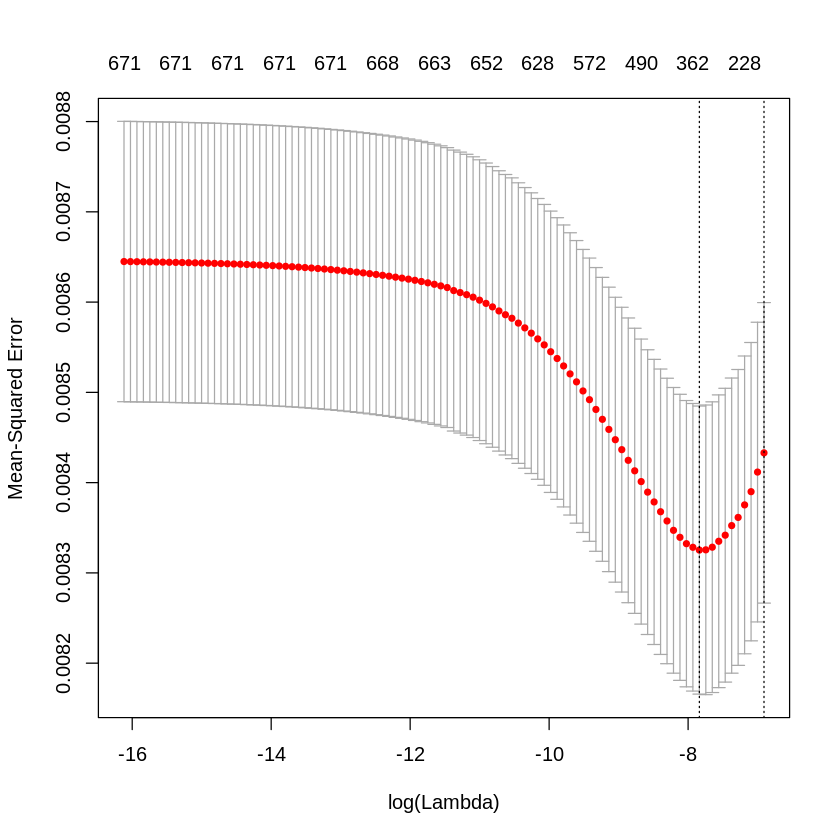

In [4]:
set.seed(0)
#X==predictor
#y==response

y <- sum_control_ATAC_bin_rm %>% dplyr::select(ATAC_val) %>%  as.matrix()
X <- sum_control_ATAC_bin_rm %>% dplyr::select(-ATAC_val) %>% as.matrix()

lambdas_to_try <- 10^seq(-7, -3, length.out = 100)
#standardize = FALSE -- range -10 to -5
#standardize = TRUE -- range -7 to -3

lasso_cv <- cv.glmnet(X, y, alpha = 1, lambda = lambdas_to_try,
                      standardize = TRUE, nfolds = 10)

#Plotting the MSE and log(lambda)

plot(lasso_cv)

In [5]:
lambda_cv <- lasso_cv$lambda.min

Cross validation to find the RSME

In [6]:
CV_lasso<-function(data, nfolds){
    set.seed(0)
    cvfolds <- cut(1:nrow(data), breaks = nfolds, labels = F)
    cvfolds <- sample(cvfolds)
    

    predicted <- rep(NA, nrow(data))
    #data_as_matrix <- data %>% dplyr::select(-ATAC_val) %>% as.matrix() 
    
    y <- data %>% dplyr::select(ATAC_val) %>%  as.matrix()
    X <- data %>% dplyr::select(-ATAC_val) %>% as.matrix() 
    
    for (i in 1:nfolds){
        rows      <- which(cvfolds==i)
        testdata  <- X[rows,]
        traindata <- X[-rows,]
        train_y <- y[-rows,]

        fit       <- glmnet(traindata, train_y, alpha = 1, lambda = lambda_cv, standardize = TRUE)
        tmp       <- predict(fit, s=lambda_cv, testdata)
        predicted[rows] <- tmp
    }
    
    rm(tmp)
    observed <- y
    head(observed)
    mean(observed)
    se    <- (observed-predicted)^2
    mse   <- mean(se)
    (rmse <- sqrt(mse))
    
    return(tibble(observed = observed, predicted = predicted))
}

In [7]:
res_lasso_pred <- CV_lasso(sum_control_ATAC_bin_rm, 10)
#head(res_lasso_pred)

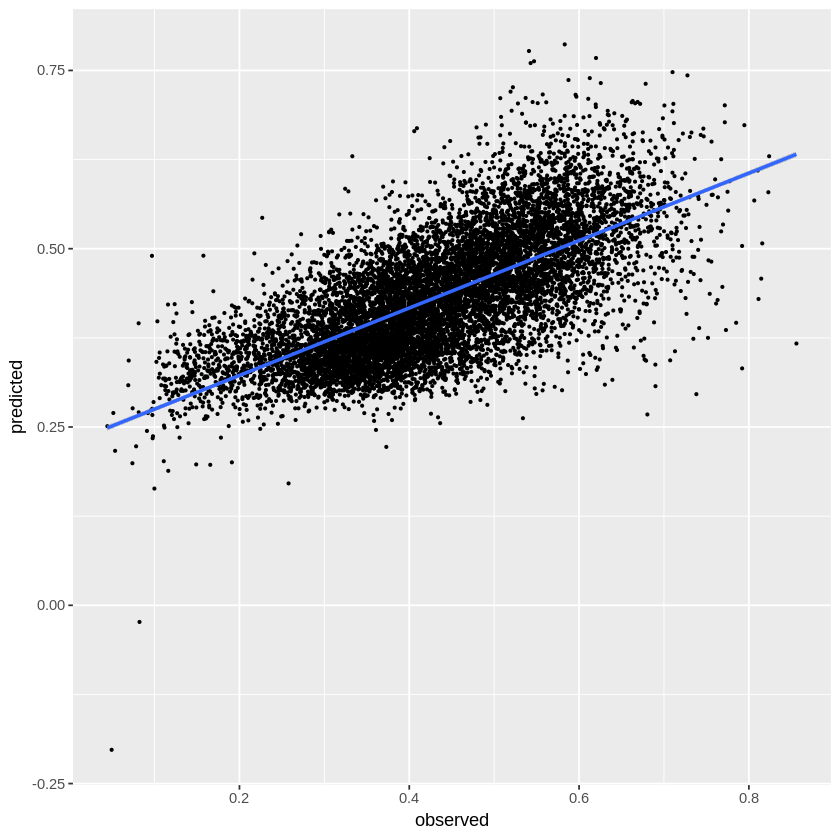

In [8]:
ggplot(res_lasso_pred, aes(x = observed, y = predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [9]:
cor(res_lasso_pred$observed, res_lasso_pred$predicted)

# Standardize = TRUE: ATAC_val 0.6863115
# Standardize = FALSE: ATAC_val 0.6902794

ATAC_val,0.6863115


Coefficients

In [10]:
y <- sum_control_ATAC_bin_rm %>% dplyr::select(ATAC_val) %>%  as.matrix()
X <- sum_control_ATAC_bin_rm %>% dplyr::select(-ATAC_val) %>% as.matrix()

fit <- glmnet(X, y, alpha = 1, lambda = lambda_cv, standardize = TRUE)
saveRDS(fit, snakemake@output[["output_model"]])

In [11]:
#predictors_used<-tibble(predictors=as.vector(rownames(model_cv$beta)),coefficient=as.vector(model_cv$beta)) 
#%>% filter(coefficient!=0)

#predictors_used<- predictors_used %>%
#  arrange(desc(abs(coefficient)))

In [12]:
#sum(abs(predictors_used$coefficient) == 0)

#dim(predictors_used %>% filter(coefficient == 0))
#sum(abs(predictors_used$coefficient) != 0)

In [13]:
#predictors_used

## Look at the outlier on the plot

In [14]:
#which.min(res_lasso_pred$predicted)

In [15]:
#colnames(sum_control_ATAC_bin_rm)
#colnames(sum_control_ATAC)

In [16]:
#sum_control_ATAC[4487,]

In [17]:
#chr20_118 <- sum_control_ATAC %>% slice(4487:4487) %>% select(-ATAC_val)

#chr20_118_long <- chr20_118 %>% pivot_longer(!bin, names_to = "bin_size", values_to = "bin_count")

#chr20_118_long$bin_size <- sub('.', '', chr20_118_long$bin_size)
#chr20_118_long$bin_size <- as.numeric(chr20_118_long$bin_size)
#head(chr20_118_long)

#p <- ggplot(chr20_118_long) + geom_col(aes(x = bin_size, y = bin_count)) + ggtitle("Outlier fragment length histogram")

#plotly::ggplotly(p)

In [18]:
#chr <- sum_control_ATAC %>% slice(1:1) %>% select(-ATAC_val)

#chr_long <- chr %>% pivot_longer(!bin, names_to = "bin_size", values_to = "bin_count")

#chr_long$bin_size <- sub('.', '', chr_long$bin_size)
#chr_long$bin_size <- as.numeric(chr_long$bin_size)
#head(chr_long)

#p <- ggplot(chr_long) + geom_col(aes(x = bin_size, y = bin_count)) + ggtitle("Another bin fragment length histogram (for comparison)")

#plotly::ggplotly(p)

## Plot the observed and predicted ATAC values

In [19]:
#res_lasso_pred$bin <- sum_control_ATAC$bin
#res_lasso_pred$bin <- sub('...', '', res_lasso_pred$bin)
#head(res_lasso_pred)
#res_lasso_pred <- res_lasso_pred %>% separate(bin, c("chr", "bin_number"), sep = "_")

In [20]:
#str(res_lasso_pred)
#res_lasso_pred$chr <- as.numeric(res_lasso_pred$chr)
#res_lasso_pred$bin_number <- as.numeric(res_lasso_pred$bin_number)
#res_lasso_pred <- res_lasso_pred %>% mutate(position = bin_number*250000)
#res_lasso_pred <- res_lasso_pred %>% arrange(chr, position)
#head(res_lasso_pred)


In [21]:
#res_lasso_pred_chr1 <- res_lasso_pred %>% filter(chr == 1)

#colors <- c("observed" = "firebrick", "predicted" = "darkblue")

#p <- ggplot(res_lasso_pred_chr1) + 
        #geom_point(aes(x = position, y = observed, color = "observed"), size = 0.5) + 
        #geom_line(aes(x = position, y = observed, color = "observed"), size = 0.3) + 
        #geom_point(aes(x = position, y = predicted, color = "predicted"), size = 0.5) + 
        #geom_line(aes(x = position, y = predicted, color = "predicted"), size = 0.3) +
        #labs(x = "Position",
             #y = "ATAC value",
             #color = "Legend") +
        #scale_color_manual(values = colors)

#plotly::ggplotly(p)

In [22]:
#p <- ggplot(res_lasso_pred_chr1) + 
        #geom_col(aes(x = position, y = observed, fill = "observed", alpha = 0.5)) + 
        #geom_col(aes(x = position, y = predicted, fill = "predicted", alpha = 0.5)) + 
        #labs(x = "Position",
             #y = "ATAC value",
             #color = "Legend") +
        #scale_fill_manual(values = colors)

#plotly::ggplotly(p)

## Make predictions on all of the samples

In [23]:
#filename = "data/all_samples_normalized.csv"
filename = snakemake@input[["input_test_data_smooth"]]

In [24]:
cols_predictions = as.data.frame(t(c("sample", "bin", "ATAC_prediction")))

In [25]:
# Initiate the empty files and add column names


write.table(NULL, file=snakemake@output[["output_pred"]], 
             append = F, 
             sep=',', 
             row.names=F, 
             col.names=F)

#colnames_pred <- c("sample", "bin", "ATAC_prediction")


write.table(cols_predictions, snakemake@output[["output_pred"]], append = F, sep=',', col.names=F, row.names=F)

In [26]:
f <- function(df1, pos) {

    df1[3:673] <- lapply(df1[3:673], as.numeric)
    
    df <- df1 %>% select(-c("sample", "bin")) %>% as.matrix()
    tmp       <- as.vector(predict(fit, s=lambda_cv, df))
    
    tmp <- tibble(sample = df1$sample, bin = df1$bin, ATAC_prediction = tmp)
    #message(tmp)
    write.table(tmp, snakemake@output[["output_pred"]], append = TRUE, sep=',', col.names=F, row.names=F)
}

df <- read_csv_chunked(file = filename, 
                 callback = DataFrameCallback$new(f), 
                 chunk_size = 10000, col_names = T,
                 #delim = ",", 
                 progress = show_progress())

Parsed with column specification:
cols(
  .default = col_double(),
  sample = col_character(),
  bin = col_character()
)
See spec(...) for full column specifications.
